# Анализ данных разработчика мобильных игр.

## Задачи.
1. Написать функцию для подсчета Retention по дням от даты регистрации игрока.
2. В компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных нужно определить, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложить метрики для оценки результатов последнего прошедшего тематического события в игре.

In [139]:
# Импортируем необходимые библиотеки

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# 1. Функция для подсчета Retention.

In [2]:
# Подгрузим данные по регистрациям

reg_path = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/IXfIB4XcJVjTBA'

In [3]:
reg = pd.read_csv(reg_path, sep=';')

In [4]:
reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [5]:
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [6]:
# Подгрузим данные по авторизациям

auth_path = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/iBTc5cYQStvm_w'

In [7]:
auth = pd.read_csv(auth_path, sep=';')

In [8]:
auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [9]:
auth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


Создадим 3 функции для разных целей:
1. Пользователь задает способ расчета, период регистраций и день Retention. Функция возвращает одно значение.
2. Пользователь задает способ расчета, период регистраций и временной отрезок для Retention. Функция возвращает график с динамикой за выбранный период.
3. Пользователь задает способ расчета, период регистраций и временной отрезок для Retention. Функция возвращает когортный анализ Retention.

План работы функций следующий:
1. Объединить 2 аргумента (датафрейма).
2. Завести колонку с кол-вом прошедших дней с даты регистрации. 
3. Создать финальную таблицу.
4. Извлечь из таблицы необходимые данные и/или визуализировать.

Сначала проверим код на небольших выборках, затем соберем функции.

In [10]:
# Объединим данные

df = auth.merge(reg, on='uid')

Из множества видов выберем классический N-Day Retention, т.к. он наиболее распространен и универсален, а мобильные игры предполагают в основном короткие партии, различные поощрения за вход в игру и/или действия в ней, чтобы пользователи заходили каждый день, хотя бы на короткий промежуток времени, поэтому именно этот вариант нам подходит лучше всего. При наличии возможности собрать требования, можно было бы также предложить Return Retention.

Рассчитывать будем 2мя способами:
1. Календарным: перевести время из UNIX в обычный формат и просто смотреть по датам, сколько дней прошло.
2. На основе окон в 24 часа: оставить текущий формат и отсчитывать по 24 часа.

Когорты будем смотреть по дням, т.к. функции нужны для частого использования. В некоторых ситуациях может быть правильней делить пользователей по неделям или месяцам, например, когда идут какие-то акции, внутриигровые события, тестируется новый патч, и мы хотим видеть их влияние на Retention, но для таких временных горизонтов большого смысла писать функции нет, несколько раз в год можно корректировать код под каждую ситуацию и различные задачи.

In [11]:
# Календарный расчет

# Создадим тестовый ДФ меньшего объема

calendar = df.head(100000).copy()

In [12]:
calendar.head()

,auth_ts,uid,reg_ts
0,911382223,1,911382223
1,932683089,2,932683089
2,932921206,2,932683089
3,933393015,2,932683089
4,933875379,2,932683089


In [13]:
# Переведем время из UNIX в формат дат

calendar.auth_ts = pd.to_datetime(calendar.auth_ts,
                                  unit='s').dt.date
calendar.reg_ts = pd.to_datetime(calendar.reg_ts,
                                 unit='s').dt.date

In [14]:
# Создадим колонку с кол-вом прошедших дней

calendar['days_passed'] = (calendar.auth_ts - calendar.reg_ts).dt.days

In [15]:
calendar.head()

,auth_ts,uid,reg_ts,days_passed
0,1998-11-18,1,1998-11-18,0
1,1999-07-22,2,1999-07-22,0
2,1999-07-25,2,1999-07-22,3
3,1999-07-31,2,1999-07-22,9
4,1999-08-05,2,1999-07-22,14


In [16]:
# Посчитаем, сколько пользователей вернулось на свой N-day

calendar = calendar.groupby(['reg_ts', 'days_passed'], 
                            as_index=False).uid.nunique()

In [17]:
calendar.head()

,reg_ts,days_passed,uid
0,1998-11-18,0,1
1,1999-07-22,0,1
2,1999-07-22,3,1
3,1999-07-22,9,1
4,1999-07-22,14,1


In [18]:
# Разобьем пользователей на когорты, покажем кол-во возвратов по дням

cohorts_c = calendar.pivot(index='reg_ts', 
                           columns='days_passed', 
                           values='uid') \
                    .fillna(0) \
                    .astype(int)

In [19]:
cohorts_c.head()

days_passed,0,1,2,3,4,5,6,7,8,9,...,7701,7704,7706,7709,7712,7716,7720,7721,7727,7729
reg_ts,,,,,,,,,,,,,,,,,,,,,
1998-11-18,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-07-22,1,0,0,1,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
2000-01-13,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-05-28,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-09-16,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


На основе этого ДФа можно получить все необходимые нам данные для расчета календарным путем.

Создадим ДФ для расчета по 24-часовым окнам.

In [20]:
# Расчет по окнам

window = df.head(100000).copy()

In [21]:
window.head()

,auth_ts,uid,reg_ts
0,911382223,1,911382223
1,932683089,2,932683089
2,932921206,2,932683089
3,933393015,2,932683089
4,933875379,2,932683089


In [22]:
# Сохраним размер окна в переменную

secs_in_day = 24 * 60 * 60

In [23]:
# Создадим колонку с кол-вом прошедших окон

window['days_passed'] = (window.auth_ts - window.reg_ts) // secs_in_day

In [24]:
window.head()

,auth_ts,uid,reg_ts,days_passed
0,911382223,1,911382223,0
1,932683089,2,932683089,0
2,932921206,2,932683089,2
3,933393015,2,932683089,8
4,933875379,2,932683089,13


In [25]:
# Переведем время регистрации из UNIX в формат дат

window.reg_ts = pd.to_datetime(window.reg_ts,
                               unit='s').dt.date

In [26]:
# Посчитаем, сколько пользователей вернулось на свой N-day

window = window.groupby(['reg_ts', 'days_passed'], as_index=False).uid.nunique()

In [27]:
window.head()

,reg_ts,days_passed,uid
0,1998-11-18,0,1
1,1999-07-22,0,1
2,1999-07-22,2,1
3,1999-07-22,8,1
4,1999-07-22,13,1


In [28]:
# Разобьем пользователей на когорты, покажем кол-во возвратов по дням

cohorts_w = window.pivot(index='reg_ts', 
                         columns='days_passed', 
                         values='uid') \
                  .fillna(0) \
                  .astype(int)

In [29]:
cohorts_w.head()

days_passed,0,1,2,3,4,5,6,7,8,9,...,7700,7703,7705,7708,7711,7715,7719,7720,7726,7728
reg_ts,,,,,,,,,,,,,,,,,,,,,
1998-11-18,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-07-22,1,0,1,0,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1
2000-01-13,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-05-28,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-09-16,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Теперь, когда исходные данные готовы, пройдем по функциям, которые хотим реализовать.

Чтобы не повторяться, все задачи будем выполнять на календарном ДФе.

Решим следующие задачи:
1. Retention 7 дня для пользователей, зарегистрировавшихся в 2002 году.
2. График Retention первой 1й недели для пользователей, зарегистрировавшихся в 2003 году.
3. Для пользователей, зарегистрировавшихся в последнем квартале 2004 года, показать когорты и Retention первых 2х недель.

In [42]:
# Retention 7го дня

# За сегодняшнюю дату возьмем последнюю из ДФа

today = df.head(100000).auth_ts.max()
today = pd.to_datetime(today, unit='s').date()

In [80]:
# Уберем когорты, у которых еще не прошло 7 дней,
# Оставим регистрации только 2002 года

day_7 = cohorts_c.copy()[((today - cohorts_c.index) >= '7 days') &
                         ((cohorts_c.index < datetime.date(2003, 1, 1)) &
                          (cohorts_c.index > datetime.date(2001, 12, 31)))]

In [87]:
# Посчитаем Retention

((day_7[7].sum() / day_7[0].sum()) * 100).round(1)

20.0

В нашем урезанном ДФе Retention 7 дня для пользователей, зарегистрировавшихся в 2002 году, равен 20%.

In [90]:
# График Retention первой недели

# Уберем когорты, у которых не прошло недели,
# Оставим регистрации за 2003 год

week_1 = cohorts_c.copy()[((today - cohorts_c.index) >= '7 days') &
                         ((cohorts_c.index < datetime.date(2004, 1, 1)) &
                          (cohorts_c.index > datetime.date(2002, 12, 31)))]

In [94]:
# Создадим список со значениями Retention,
# Зададим отрезок времени,
# Посчитаем Retention для каждого дня

r_results = []
days = 7

for i in range(days + 1):
    r = ((week_1[i].sum() / week_1[0].sum()) * 100).round(1)
    r_results.append(r)

In [95]:
# Создадим список с днями

r_days = list(range(days + 1))

In [96]:
# Соберем ДФ

r_graph = pd.DataFrame({'n_day': r_days,
                        'retention': r_results})

In [98]:
r_graph

,n_day,retention
0,0,100.0
1,1,0.0
2,2,5.0
3,3,10.0
4,4,5.0
5,5,0.0
6,6,10.0
7,7,15.0


[Text(0.5, 0, 'N-Day'), Text(0, 0.5, 'Retention, %')]

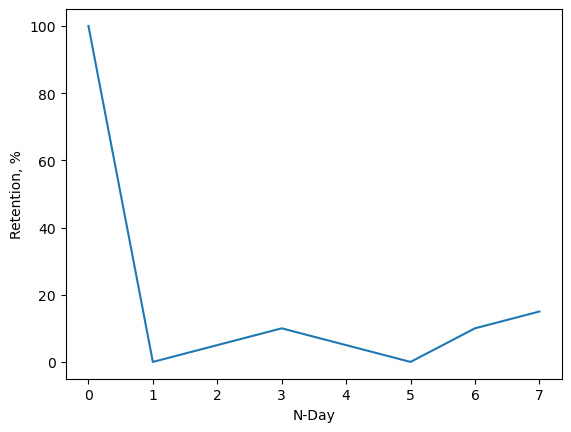

In [100]:
# Построим график

g_r7 = sns.lineplot(data=r_graph,
                    x='n_day',
                    y='retention')
g_r7.set(xlabel='N-Day',
         ylabel='Retention, %')

На графике динамика Retention первой 1й недели для пользователей, зарегистрировавшихся в 2003 году.

In [207]:
# Когортный анализ Retention

# Выберем когорты за 2004й год
 
week_2 = cohorts_c.copy()[(cohorts_c.index < datetime.date(2005, 1, 1)) &
                          (cohorts_c.index > datetime.date(2004, 9, 30))] \
                         [list(range(0, 15))]

In [208]:
# Для когорт, которые еще не дошли до соответствующих дней,
# меняем 0 на пустые значения

for i in range(len(week_2.index)):
    for j in range(len(week_2.columns)):
        if week_2.index[i] + pd.Timedelta(days=j) > today:
            week_2.loc[week_2.index[i], week_2.columns[j]] = np.nan

In [209]:
# Переведем значения в проценты

week_2 = week_2.div(week_2[0], axis=0).mul(100).round(1)

In [210]:
week_2.head()

days_passed,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
reg_ts,,,,,,,,,,,,,,,
2004-10-01,100.0,0.0,0.0,100.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
2004-10-10,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004-10-19,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
2004-10-28,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004-11-05,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0, 0, '')

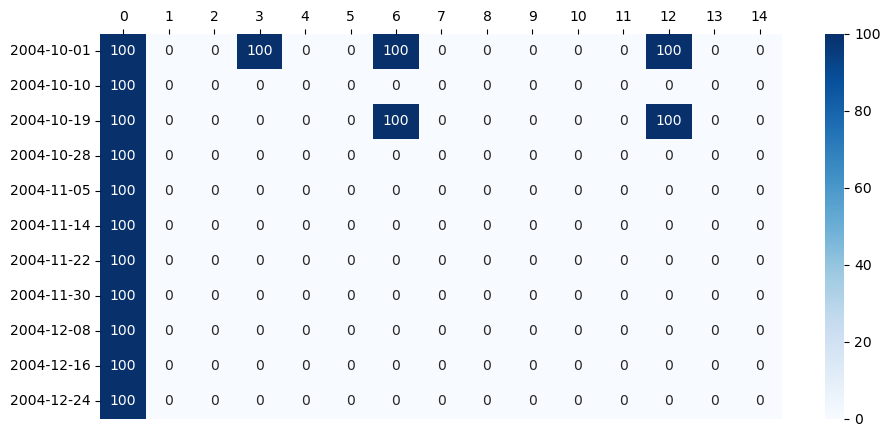

In [224]:
# Визуализируем данные

f, ax = plt.subplots(figsize=(11, 5))
g_w2 = sns.heatmap(week_2, annot=True, cmap='Blues', fmt='g')
g_w2.xaxis.tick_top()
g_w2.set(xlabel=None, ylabel=None)
plt.yticks(rotation=0)
g_w2.text(0, 0, '')

По графикам такого формата можно сравнивать Retention у разных когорт.

Можно собирать функции.

In [235]:
# Функция 1, возвращающая значение Retention N-Day

def retention_nday(reg_path, 
                   auth_path, 
                   r_type, 
                   min_reg, 
                   max_reg, 
                   nday):
    '''
Функция принимает следующие аргументы и параметры:
1. Пути к файлам с данными о регистрациях и авторизациях(reg_path, auth_path).
Укажите путь к файлу в двойных или одинарных кавычках.
2. Способ расчета Retention(r_type). 
Укажите в двойных или одинарных кавычках "с" для календарного способа, "w" для оконного.
3. Период регистраций(min_reg, max_reg). 
Укажите в двойных или одинарных кавычках минимальную и максимальную даты регистрации 
для выборки в формате "гггг-мм-дд".
4. N-Day Retention(nday). 
Укажите день, для которого необходимо посчитать Retention. 
    
Функция возвращает значение Retention указанного дня.'''

In [236]:
print(retention_nday.__doc__)


Функция принимает следующие аргументы и параметры:
1. Пути к файлам с данными о регистрациях и авторизациях(reg_path, auth_path).
Укажите путь к файлу в двойных или одинарных кавычках.
2. Способ расчета Retention(r_type). 
Укажите в двойных или одинарных кавычках "с" для календарного способа, "w" для оконного.
3. Период регистраций(min_reg, max_reg). 
Укажите в двойных или одинарных кавычках минимальную и максимальную даты регистрации 
для выборки в формате "гггг-мм-дд".
4. N-Day Retention(nday). 
Укажите день, для которого необходимо посчитать Retention. 
    
Функция возвращает значение Retention указанного дня.
